Class distribution:
Class 0: 1805 instances
Class 1: 1805 instances
Class 2: 1999 instances
Class 3: 1805 instances
Class 4: 1805 instances


/tmp/ipykernel_1928129/1697008116.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")


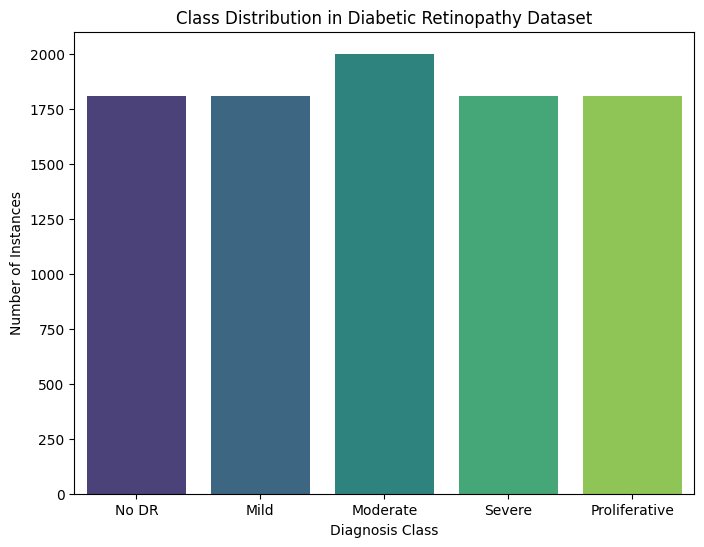

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the training data
data = pd.read_csv("/home/gcekcse/Documents/ML_Project_hk/data/augmented_train.csv")

# Count the number of instances per class (0 to 4 in the 'diagnosis' column)
class_counts = data['diagnosis'].value_counts().sort_index()

# Print the number of instances for each class
print("Class distribution:")
for diagnosis_class, count in class_counts.items():
    print(f"Class {diagnosis_class}: {count} instances")

# Plot the class distribution
plt.figure(figsize=(8, 6))
sns.barplot(x=class_counts.index, y=class_counts.values, palette="viridis")
plt.title("Class Distribution in Diabetic Retinopathy Dataset")
plt.xlabel("Diagnosis Class")
plt.ylabel("Number of Instances")
plt.xticks(ticks=class_counts.index, labels=['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'])
plt.show()


In [4]:
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

# Load the data
data = pd.read_csv("/home/gcekcse/Documents/ML_Project_hk/data/augmented_train.csv")
image_dir = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_images"

# Define the number of samples to display per class
num_samples = 10

# Create a figure with subplots
plt.figure(figsize=(20, 20))

# Loop over each class (0 to 4)
for diagnosis_class in range(5):
    # Filter DataFrame for the current class and sample 10 images
    class_images = data[data['diagnosis'] == diagnosis_class].sample(num_samples, random_state=42)
    
    # Display each image in the grid
    for i, (_, row) in enumerate(class_images.iterrows()):
        img_path = os.path.join(image_dir, row['id_code'] + '.png')
        try:
            image = Image.open(img_path)
            plt.subplot(5, num_samples, diagnosis_class * num_samples + i + 1)
            plt.imshow(image)
            plt.axis('off')
            if i == 0:
                plt.title(['No DR', 'Mild', 'Moderate', 'Severe', 'Proliferative'][diagnosis_class], fontsize=16)
        except Exception as e:
            print(f"Error loading image {img_path}: {e}")

plt.tight_layout()
plt.show()


Error loading image /home/gcekcse/Documents/ML_Project_hk/data/augmented_images/ef5155990874.png: [Errno 2] No such file or directory: '/home/gcekcse/Documents/ML_Project_hk/data/augmented_images/ef5155990874.png'
Error loading image /home/gcekcse/Documents/ML_Project_hk/data/augmented_images/0a85a1e8f9e9.png: [Errno 2] No such file or directory: '/home/gcekcse/Documents/ML_Project_hk/data/augmented_images/0a85a1e8f9e9.png'
Error loading image /home/gcekcse/Documents/ML_Project_hk/data/augmented_images/6a2642131e4a.png: [Errno 2] No such file or directory: '/home/gcekcse/Documents/ML_Project_hk/data/augmented_images/6a2642131e4a.png'
Error loading image /home/gcekcse/Documents/ML_Project_hk/data/augmented_images/8a8a251770cd.png: [Errno 2] No such file or directory: '/home/gcekcse/Documents/ML_Project_hk/data/augmented_images/8a8a251770cd.png'
Error loading image /home/gcekcse/Documents/ML_Project_hk/data/augmented_images/ac1667fac512.png: [Errno 2] No such file or directory: '/home/gc

<Figure size 2000x2000 with 0 Axes>

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from tqdm import tqdm
import sys
import tensorflow as tf

# Ensure TensorFlow uses GPU
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if physical_devices:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

# Path to image dataset and labels
data_dir = 'C:/Users/heman/Documents/ML_project/aptos2019-blindness-detection/G1/G1_images'
labels_file = 'C:/Users/heman/Documents/ML_project/aptos2019-blindness-detection/G1/G1.csv'
class_dir = 'C:/Users/heman/Documents/ML_project/aptos2019-blindness-detection/G1/classes'

# Load labels
df = pd.read_csv(labels_file)

# Augment data for classes with fewer images
min_samples = df['diagnosis'].value_counts().max()  # The maximum class size
batch_size = 5  # Smaller batch size due to limited memory

# Data augmentation parameters
datagen = ImageDataGenerator(rotation_range=20,
                             zoom_range=0.15,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             shear_range=0.15,
                             horizontal_flip=True,
                             fill_mode="nearest")

def augment_and_save(image, save_dir, base_name, num_augmented=1):
    image = np.expand_dims(image, 0)  # Add batch dimension
    i = 0
    for batch in datagen.flow(image, batch_size=1, save_to_dir=save_dir,
                              save_prefix=base_name, save_format='png'):
        i += 1
        del batch  # Clear batch from memory
        if i >= num_augmented:
            break

# Function to print and clear the previous line
def clear_line():
    sys.stdout.write("\r")  # Carriage return
    sys.stdout.flush()  # Flush buffer to avoid delay

# Perform augmentation in batches
with tqdm(total=len(df['diagnosis'].unique()), desc="Processing classes", leave=True, ncols=100, mininterval=1) as outer_bar:
    for class_label in df['diagnosis'].unique():
        class_folder = os.path.join(class_dir, str(class_label))
        class_images = df[df['diagnosis'] == class_label]
        num_samples = len(class_images)
        
        if num_samples < min_samples:  # Augment only for classes with fewer samples
            augment_needed = min_samples - num_samples
            
            # Process images in batches
            for i in range(0, len(class_images), batch_size):
                batch_images = class_images.iloc[i:i + batch_size]
                
                for idx, row in batch_images.iterrows():
                    clear_line()  # Clear previous line
                    print(f"Augmenting class {class_label}: {idx + 1}/{len(class_images)}", end="")  # Print current progress

                    img_name = row['id_code'] + '.png'
                    img_path = os.path.join(data_dir, img_name)
                    
                    if os.path.exists(img_path):
                        img = cv2.imread(img_path)
                        if img is not None:
                            # Resize image to reduce memory usage
                            img = cv2.resize(img, (1024, 1024))
                            # Augment images and save them in the same class folder
                            augment_and_save(img, class_folder, row['id_code'], num_augmented=augment_needed // num_samples + 1)
        outer_bar.update(1)

print("\nData augmentation completed.")


Processing classes:   0%|                                                     | 0/5 [00:00<?, ?it/s]

Augmenting class 2: 3662/999

Processing classes:  20%|████████▏                                | 1/5 [21:47<1:27:11, 1307.98s/it]

Augmenting class 4: 3657/295

Processing classes:  40%|████████████████▍                        | 2/5 [56:38<1:28:24, 1768.08s/it]

Augmenting class 1: 2256/370

In [3]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import shutil

# Paths to your dataset folders and CSV file
data_dir = "/home/gcekcse/Documents/ML_Project_hk/data/train_images"
output_dir = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_images"
csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/train.csv"

# Load the CSV data
data = pd.read_csv(csv_path)

# Define augmentation for fundus images
datagen = ImageDataGenerator(
    rotation_range=15,       
    horizontal_flip=True,    
    vertical_flip=True,      
    brightness_range=[0.8, 1.2],
)

# Dictionary for the augmentation targets
augmentation_targets = {
    1: 1435,  
    2: 806,   
    3: 1612,  
    4: 1510,  
}

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to hold new entries for the updated CSV
new_entries = []

# Copy original images to the output directory and augment
for diagnosis_class, target_count in augmentation_targets.items():
    # Filter the dataset for the current class
    class_data = data[data['diagnosis'] == diagnosis_class]
    
    # Copy original images to the output directory
    for _, row in class_data.iterrows():
        original_image_path = os.path.join(data_dir, row['id_code'] + '.png')
        shutil.copy(original_image_path, output_dir)
        
        # Add the original entry to the new entries list
        new_entries.append({'id_code': row['id_code'], 'diagnosis': diagnosis_class})

    image_count = len(class_data)
    images_to_generate = target_count - image_count
    
    # Loop through each image in the class and augment until we reach target count
    generated_count = 0
    for _, row in class_data.iterrows():
        image_path = os.path.join(data_dir, row['id_code'] + '.png')
        try:
            # Open image
            image = Image.open(image_path)
            image_array = np.expand_dims(np.array(image), 0)
            
            # Generate augmented images
            for batch in datagen.flow(image_array, batch_size=1, save_to_dir=output_dir, 
                                      save_prefix=f"{row['id_code']}_aug", save_format='png'):
                generated_count += 1
                
                # Create a new entry for the updated CSV
                new_entries.append({'id_code': f"{row['id_code']}_aug", 'diagnosis': diagnosis_class})
                
                if generated_count >= images_to_generate:
                    break
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
        
        if generated_count >= images_to_generate:
            break

# Create a DataFrame from the new entries
new_df = pd.DataFrame(new_entries)

# Append new data to the original DataFrame
updated_data = pd.concat([data, new_df], ignore_index=True)

# Save the updated DataFrame to a new CSV file
updated_csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_train.csv"
updated_data.to_csv(updated_csv_path, index=False)

print("Augmentation completed, original images copied, and CSV updated.")


2024-11-04 15:27:42.172288: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-04 15:27:42.286399: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-04 15:27:42.356075: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-04 15:27:42.374944: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-04 15:27:42.455305: I tensorflow/core/platform/cpu_feature_guar

Augmentation completed, original images copied, and CSV updated.


In [1]:
import os
import shutil
import pandas as pd

# Paths
output_dir = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_images"
csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_train.csv"

# Load the updated CSV data
data = pd.read_csv(csv_path)

# Create class subdirectories in the output directory
for class_label in range(5):  # Assuming classes are labeled from 0 to 4
    class_dir = os.path.join(output_dir, str(class_label))
    os.makedirs(class_dir, exist_ok=True)

# Move images to their respective class directories
for _, row in data.iterrows():
    image_name = row['id_code'] + '.png'
    image_path = os.path.join(output_dir, image_name)
    
    # Check if the image exists before moving
    if os.path.exists(image_path):
        class_label = row['diagnosis']
        target_class_dir = os.path.join(output_dir, str(class_label))
        shutil.move(image_path, target_class_dir)

print("Augmented images have been separated into class folders.")


Augmented images have been separated into class folders.


In [2]:
import pandas as pd
import os

# Paths to your dataset folders and CSV file
data_dir = "/home/gcekcse/Documents/ML_Project_hk/data/train_images"
csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/train.csv"

# Load the CSV data
data = pd.read_csv(csv_path)

# List to store missing files
missing_files = []

# Check if the image files listed in the CSV exist in the train directory
for _, row in data.iterrows():
    image_path = os.path.join(data_dir, row['id_code'] + '.png')
    
    if not os.path.exists(image_path):
        missing_files.append(row['id_code'])  # Store the missing image ID

# Report results
if missing_files:
    print("Missing files:")
    for file in missing_files:
        print(file)
else:
    print("All files exist in the train_images directory.")


All files exist in the train_images directory.


In [1]:
import pandas as pd
import os
import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from PIL import Image
import shutil
from tqdm import tqdm

# Paths to your dataset folders and CSV file
data_dir = "/home/gcekcse/Documents/ML_Project_hk/data/train_images"
output_dir = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_images"
csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/train.csv"

# Load the CSV data
data = pd.read_csv(csv_path)

# Define augmentation for fundus images
datagen = ImageDataGenerator(
    rotation_range=15,       
    horizontal_flip=True,    
    vertical_flip=True,      
    brightness_range=[0.8, 1.2],
)

# Dictionary for the augmentation targets
augmentation_targets = {
    1: 1435,  
    2: 806,   
    3: 1612,  
    4: 1510,  
}

# Create output directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# List to hold new entries for the updated CSV
new_entries = []

# Outer loop over each class with tqdm
for diagnosis_class, target_count in tqdm(augmentation_targets.items(), desc="Processing Classes"):
    # Filter the dataset for the current class
    class_data = data[data['diagnosis'] == diagnosis_class]
    
    # Copy original images to the output directory
    for _, row in class_data.iterrows():
        original_image_path = os.path.join(data_dir, row['id_code'] + '.png')
        shutil.copy(original_image_path, output_dir)
        
        # Add the original entry to the new entries list
        new_entries.append({'id_code': row['id_code'], 'diagnosis': diagnosis_class})

    image_count = len(class_data)
    images_to_generate = target_count - image_count
    
    # Loop through each image in the class and augment until we reach target count
    generated_count = 0
    for _, row in class_data.iterrows():
        image_path = os.path.join(data_dir, row['id_code'] + '.png')
        try:
            # Open image
            image = Image.open(image_path)
            image_array = np.expand_dims(np.array(image), 0)
            
            # Generate augmented images
            for batch in datagen.flow(image_array, batch_size=1, save_to_dir=output_dir, 
                                      save_prefix=f"{row['id_code']}_aug", save_format='png'):
                generated_count += 1
                
                # Create a new entry for the updated CSV
                new_entries.append({'id_code': f"{row['id_code']}_aug", 'diagnosis': diagnosis_class})
                
                if generated_count >= images_to_generate:
                    break
        except Exception as e:
            print(f"Error processing image {image_path}: {e}")
        
        if generated_count >= images_to_generate:
            break

# Create a DataFrame from the new entries
new_df = pd.DataFrame(new_entries)

# Append new data to the original DataFrame
updated_data = pd.concat([data, new_df], ignore_index=True)

# Save the updated DataFrame to a new CSV file
updated_csv_path = "/home/gcekcse/Documents/ML_Project_hk/data/augmented_train.csv"
updated_data.to_csv(updated_csv_path, index=False)

print("Augmentation completed, original images copied, and CSV updated.")


2024-11-06 16:11:07.796774: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-06 16:11:07.808482: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-06 16:11:07.821462: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-06 16:11:07.825516: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-06 16:11:07.835056: I tensorflow/core/platform/cpu_feature_guar

FileNotFoundError: [Errno 2] No such file or directory: '/home/gcekcse/Documents/ML_Project_hk/data/train_images/000c1434d8d7.png'